In [1]:
import os

os.chdir("../")

from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

load_dotenv(".env")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import constants
from src.model.wrappers import BinaryModelWrapper
from src.model.architectures import TransformerBinaryClassifier
from src.model.datasets import SlidingWindowDataset

TEXT_COLOR = "#313131"
# Plotly colors
LINE_COLORS = [
    "#636EFA",
    "#EF553B",
    "#00CC96",
    "#AB63FA",
    "#FFA15A",
    "#19D3F3",
    "#FF6692",
    "#B6E880",
    "#FF97FF",
    "#FECB52",
]

sns.set(
    style="darkgrid",
    rc={
        "figure.figsize": (6, 4),
        "figure.dpi": 100,
        "figure.facecolor": "w",
        "legend.facecolor": "w",
        "text.color": TEXT_COLOR,
        "font.family": "Microsoft Sans Serif",
        "axes.labelcolor": TEXT_COLOR,
        "xtick.color": TEXT_COLOR,
        "ytick.color": TEXT_COLOR,
    },
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
DEVICE

device(type='cpu')

# Create dataset

In [4]:
from src.features.feature_service import FeatureService

from src.features.feature_generators.technical_indicators import * #EMA, SMA, BB, OBV, MACD, RSI
from src.features.feature_generators.datetime import DateTime

In [5]:
df = pd.read_parquet("data/binance")

In [6]:
symbols = [
    f"{asset}{constants.FIAT_TO_TRADE}" 
    for asset in [constants.ASSET_TO_TRADE, *constants.PREDICTOR_ASSETS] 
]

generators = []

# Moving averages
generators += [
    indicator(input_col=f"{symbol}_close", period=period)
    for indicator in [EMA, SMA]
    for symbol in symbols
    for period in [9, 21, 50]
]

# MACD
generators += [
    MACD(
        input_col=f"{symbol}_close", 
        fast_period=12, 
        slow_period=26, 
        signal_period=9,
    )
    for symbol in symbols
]

# RSI
generators += [
    RSI(input_col=f"{symbol}_close")
    for symbol in symbols
]

# Bollinger bands
generators += [
    BB(input_col=f"{symbol}_close")
    for symbol in symbols
]

# OBV
generators += [
    OBV(
        open_col=f"{symbol}_open",
        close_col=f"{symbol}_close",
        high_col=f"{symbol}_high",
        low_col=f"{symbol}_low",
        volume_col=f"{symbol}_volume",
    )
    for symbol in symbols
]

# DateTime
generators += [
    DateTime(timestamp_col="open_timestamp")
]

In [7]:
service = FeatureService(*generators)

In [8]:
sample_df = df.iloc[:1000]

In [9]:
%%time
service.initialize(sample_df)

CPU times: user 266 ms, sys: 5.85 ms, total: 272 ms
Wall time: 272 ms


In [11]:
from talipp.indicators import SMA as SMA_talipp

In [10]:
%%time
# Features DF
pd.DataFrame(service.output_values).dropna()

CPU times: user 19.5 ms, sys: 1.41 ms, total: 20.9 ms
Wall time: 20.3 ms


,EMA__ETHUSDT_close__9,EMA__ETHUSDT_close__21,EMA__ETHUSDT_close__50,EMA__BTCUSDT_close__9,EMA__BTCUSDT_close__21,EMA__BTCUSDT_close__50,EMA__LTCUSDT_close__9,EMA__LTCUSDT_close__21,EMA__LTCUSDT_close__50,EMA__XRPUSDT_close__9,...,OBV__BTCUSDT_close,OBV__LTCUSDT_close,OBV__XRPUSDT_close,OBV__ADAUSDT_close,OBV__BNBUSDT_close,DateTime__day_of_week__4,DateTime__month__2,DateTime__quarter__1,DateTime__time_of_day__morning,DateTime__time_of_day__night
49,106.129505,106.135853,106.199200,3433.195679,3432.674266,3432.955400,31.487023,31.474201,31.462600,0.307528,...,-88.821241,-761.51436,-501644.2,304955.7,-6930.87,1.0,1.0,1.0,0.0,1.0
50,106.127604,106.134412,106.196094,3433.110543,3432.682969,3432.948129,31.495618,31.479274,31.465243,0.307501,...,-101.139850,-718.26009,-552753.8,299762.6,-6060.64,1.0,1.0,1.0,0.0,1.0
51,106.120083,106.130375,106.191934,3433.050435,3432.694518,3432.942713,31.498495,31.482067,31.466998,0.307401,...,-90.528134,-728.26009,-789414.7,282892.2,-7024.74,1.0,1.0,1.0,0.0,1.0
52,106.108067,106.123977,106.186760,3432.966348,3432.688652,3432.930449,31.500796,31.484606,31.468685,0.307306,...,-103.064147,-728.26009,-971362.2,282892.2,-7024.74,1.0,1.0,1.0,0.0,1.0
53,106.092453,106.115434,106.180612,3432.689078,3432.587866,3432.877491,31.498636,31.485097,31.469521,0.307213,...,-111.984412,-736.03666,-1002238.1,272166.4,-8304.72,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106.285249,106.325223,106.466187,3454.410037,3455.689302,3457.633663,32.356274,32.341110,32.328494,0.305417,...,-22.759882,-3151.67945,-6731311.6,-3093817.2,65953.98,1.0,1.0,1.0,0.0,0.0
996,106.272199,106.315657,106.456533,3454.298030,3455.522093,3457.485284,32.357019,32.342827,32.329730,0.305380,...,-28.539369,-3184.20720,-6744106.1,-3073803.9,61380.34,1.0,1.0,1.0,0.0,0.0
997,106.255759,106.304234,106.446081,3454.054424,3455.300085,3457.312528,32.359615,32.345297,32.331309,0.305364,...,-39.100030,-3142.89550,-6721734.1,-3071352.4,57127.86,1.0,1.0,1.0,0.0,0.0
998,106.252607,106.298394,106.437999,3454.025539,3455.173713,3457.179096,32.365692,32.349361,32.333611,0.305339,...,-31.875815,-3008.55355,-6738663.2,-3088664.1,51308.31,1.0,1.0,1.0,0.0,0.0


In [12]:
service.add_value(df.iloc[-1])

In [13]:
%%time
# Features DF
pd.DataFrame(service.output_values).dropna()

CPU times: user 19.3 ms, sys: 1.22 ms, total: 20.5 ms
Wall time: 19.7 ms


,EMA__ETHUSDT_close__9,EMA__ETHUSDT_close__21,EMA__ETHUSDT_close__50,EMA__BTCUSDT_close__9,EMA__BTCUSDT_close__21,EMA__BTCUSDT_close__50,EMA__LTCUSDT_close__9,EMA__LTCUSDT_close__21,EMA__LTCUSDT_close__50,EMA__XRPUSDT_close__9,...,OBV__BTCUSDT_close,OBV__LTCUSDT_close,OBV__XRPUSDT_close,OBV__ADAUSDT_close,OBV__BNBUSDT_close,DateTime__day_of_week__4,DateTime__month__4,DateTime__quarter__2,DateTime__time_of_day__morning,DateTime__time_of_day__night
49,106.129505,106.135853,106.199200,3433.195679,3432.674266,3432.955400,31.487023,31.474201,31.462600,0.307528,...,-88.821241,-761.51436,-501644.2,304955.7,-6930.870,1.0,0.0,0.0,0.0,1.0
50,106.127604,106.134412,106.196094,3433.110543,3432.682969,3432.948129,31.495618,31.479274,31.465243,0.307501,...,-101.139850,-718.26009,-552753.8,299762.6,-6060.640,1.0,0.0,0.0,0.0,1.0
51,106.120083,106.130375,106.191934,3433.050435,3432.694518,3432.942713,31.498495,31.482067,31.466998,0.307401,...,-90.528134,-728.26009,-789414.7,282892.2,-7024.740,1.0,0.0,0.0,0.0,1.0
52,106.108067,106.123977,106.186760,3432.966348,3432.688652,3432.930449,31.500796,31.484606,31.468685,0.307306,...,-103.064147,-728.26009,-971362.2,282892.2,-7024.740,1.0,0.0,0.0,0.0,1.0
53,106.092453,106.115434,106.180612,3432.689078,3432.587866,3432.877491,31.498636,31.485097,31.469521,0.307213,...,-111.984412,-736.03666,-1002238.1,272166.4,-8304.720,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,106.272199,106.315657,106.456533,3454.298030,3455.522093,3457.485284,32.357019,32.342827,32.329730,0.305380,...,-28.539369,-3184.20720,-6744106.1,-3073803.9,61380.340,1.0,0.0,0.0,0.0,0.0
997,106.255759,106.304234,106.446081,3454.054424,3455.300085,3457.312528,32.359615,32.345297,32.331309,0.305364,...,-39.100030,-3142.89550,-6721734.1,-3071352.4,57127.860,1.0,0.0,0.0,0.0,0.0
998,106.252607,106.298394,106.437999,3454.025539,3455.173713,3457.179096,32.365692,32.349361,32.333611,0.305339,...,-31.875815,-3008.55355,-6738663.2,-3088664.1,51308.310,1.0,0.0,0.0,0.0,0.0
999,106.246086,106.291268,106.429450,3454.188431,3455.143376,3457.087366,32.370554,32.353056,32.335822,0.305313,...,-20.598229,-3008.55355,-6865671.9,-3105126.4,29311.450,1.0,0.0,0.0,0.0,0.0


---

In [40]:
def generate_binary_labels(prices: np.ndarray, interval: int) -> np.ndarray:
    """
    Label depending on relative changes in future prices.

    Parameters
    ----------
    prices: array
        Data containing features `frequency`, `recency`, and `T`
        for each `customer_id`.
    interval: int
        How many steps ahead is the future price.
        
    Returns
    -------
    Array of buy/sell/hold signals.
        0 = Sell signal. Price will drop below the threshold.
        1 = Hold signal. Price will not surpass the threshold
        2 = Buy signal. Price will rise above the threshold.
    """
    future_prices = np.roll(a=prices, shift=-interval)
    labels = (future_prices > prices).astype(int)
    return np.concatenate((labels[:-interval], interval * [np.nan]))

In [41]:
df["target"] = generate_binary_labels(
    prices=df["ADAUSDT_close"].values,
    interval=5,
)

In [42]:
df = df.dropna()

In [43]:
x = df.drop(["time", "open_timestamp", "date", "target"], axis=1)
y = df["target"]

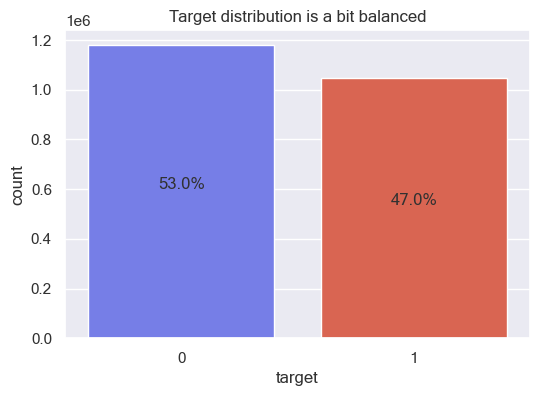

In [44]:
fig,ax = plt.subplots()
sns.countplot(x=y.astype(int), ax=ax)

# show the count in %
for p in ax.patches:
    h_, w_, x_ = p.get_height(), p.get_width(), p.get_x()
    xy_ = (x_ + w_ / 2., h_ / 2)
    pct = 100 * h_ / y.shape[0]
    text = f'{pct:0.1f}%'
    ax.annotate(text=text, xy=xy_, ha='center', va='bottom')
    
plt.title("Target distribution is a bit balanced")
plt.show()

In [45]:
# Create `x` and `y`
x = torch.tensor(x.astype(float).values).to(DEVICE).to(torch.float)
y = torch.tensor(y.values).to(DEVICE).to(torch.float)

In [23]:
# Just take a subset to try training
x_train = x[:10000]
y_train = y[:10000]

x_valid = x[10000:15000]
y_valid = y[10000:15000]

In [26]:
model = TransformerBinaryClassifier(
    n_features=x.size(1),
    n_embedding_dims=64,
    n_head=8,
    n_layers=2, 
    n_out=1,
)

In [32]:
estimator = BinaryModelWrapper(
    model=model,
    batch_size=128,
    loss_fn=torch.nn.BCELoss(),
    dataset_builder=SlidingWindowDataset,
    lr_decay_multiplier=0.9,
    lr_decay_step=5,
)

In [35]:
estimator.fit(
    x_train=x_train,
    y_train=y_train,
    x_valid=x_valid,
    y_valid=y_valid,
)

Epoch: 1 | Train Loss: 0.730 | Valid Loss: 0.788
Epoch: 2 | Train Loss: 0.731 | Valid Loss: 0.789
Epoch: 3 | Train Loss: 0.731 | Valid Loss: 0.755
Epoch: 4 | Train Loss: 0.731 | Valid Loss: 0.785
Epoch: 5 | Train Loss: 0.732 | Valid Loss: 0.802
Epoch: 6 | Train Loss: 0.732 | Valid Loss: 0.796
Epoch: 7 | Train Loss: 0.727 | Valid Loss: 0.799
Epoch: 8 | Train Loss: 0.728 | Valid Loss: 0.793
Epoch: 9 | Train Loss: 0.727 | Valid Loss: 0.791
Epoch: 10 | Train Loss: 0.728 | Valid Loss: 0.782


---